In this notebook, we will try to use the general class of frailty models with neural network components defined in "frailty_model_nn.py" to redefine the overall BCH-PVF cure model proposed by Cancho et al. (2021), which we are extending to this new class of models.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import lifelines

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, initializers

from tensorflow.keras.callbacks import Callback
from tqdm.keras import TqdmCallback
from tqdm import tqdm

import frailty_model_nn as fnn

import pvf
import weibull
import pvfnn_generate_sim_data as pvf_model

2025-10-14 05:10:38.932391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760429438.949744  629953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760429438.954987  629953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760429438.967995  629953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760429438.968026  629953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760429438.968029  629953 computation_placer.cc:177] computation placer alr

In [2]:
theta_function2 = lambda x1, x2 : 5 * np.exp(-(x1**2 + x2**2)/0.5 )

alpha_ = 0.3
mu_ = 1.0
gamma_ = 2.0
phi1_ = 2.0
phi2_ = 0.6

# n = 716
n_train = 5000
n_test = 10

rng = np.random.default_rng(1)
cens_loc = 0.0
cens_scale = 3.0

t_train, delta_train, x1_train, x2_train, theta_train, w_train, z_train, \
t_test, delta_test, x1_test, x2_test, theta_test, w_test, z_test, df = pvf_model.sample_train_test2(
    theta_function2,
    alpha_, mu_, gamma_, phi1_, phi2_,
    n_train = n_train, n_test = n_test, cens_loc = cens_loc, cens_scale = cens_scale, random_state = rng
)
print("Proportion of censoring: {}".format(1-np.mean(df["delta"])))
print("Proportion of cured: {}".format(np.mean(df["z"] == 0)))

Proportion of censoring: 0.5688622754491017
Proportion of cured: 0.49221556886227547


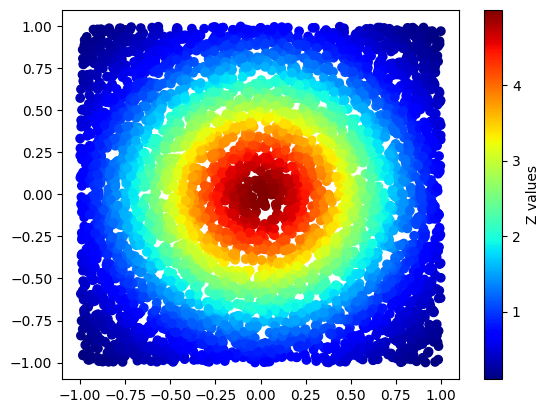

In [3]:
theta_x1_x2 = [theta_function2(df["x1"][i], df["x2"][i]) for i in range(len(df["x2"]))]
plt.scatter(df["x1"], df["x2"], c=theta_x1_x2, cmap='jet')  # 'c' sets the colors, 'cmap' is the colormap
plt.colorbar(label='Z values')
plt.show()

In order to define the model, we simply need to specify four major informations to the general class:
* The list of model parameters and their respective natures
* The negative log-likelihood function with respect to this model
* The neural network architecture used to merge possible data input to the parameters
* The call function that tells the model the order of layers is required to output from the model

In [4]:
pvf_parameters = {
    "theta": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "nn", "update_func": None, "shape": None, "initializer": None},
    "alpha": {"link": lambda x : 1/(1+tf.math.exp(-x)), "link_inv": lambda x : tf.math.log(x) - tf.math.log(1-x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.5},
    "gamma": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 1.0},
    "phi1": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 1.0},
    "phi2": {"link": lambda x : tf.identity(x), "link_inv": lambda x : tf.identity(x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.0}
}

def pvf_loglikelihood_loss(model, nn_output, t, delta):
    """
        This is an example of a correctly defined loss function.
    """
    theta = model.get_variable("theta", nn_output)

    alpha = model.get_variable("alpha")
    gamma = model.get_variable("gamma")
    phi1 = model.get_variable("phi1")
    phi2 = model.get_variable("phi2")

    log_f0 = tf.math.log(phi1) + (phi1-1)*tf.math.log(t) + phi2 - tf.math.exp(phi2) * tf.math.pow(t, phi1)
    F0 = 1 - tf.math.exp(-tf.math.pow(t, phi1) * tf.math.exp(phi2))
    laplace_transform_term = 1 + gamma*theta*F0/(1-alpha)

    loss_weights = delta*tf.math.log(theta) + delta*log_f0 + (1-alpha)/(alpha*gamma)*(1 - tf.math.pow(laplace_transform_term, alpha)) + (alpha-1)*delta*tf.math.log(laplace_transform_term)
    loss_weights_mean = -tf.math.reduce_mean(loss_weights)
    
    return loss_weights_mean

def pvf_neural_network(model, seed = None):
    """ 
        This is an example of a correctly defined neural network structure definition function.
    """
    initializer = initializers.GlorotNormal(seed = seed)
    model.dense1 = keras.layers.Dense(units = 16, activation = "tanh", kernel_initializer = initializer, dtype = tf.float32, name = "dense1")
    model.dense2 = keras.layers.Dense(units = 1, kernel_initializer = initializer, dtype = tf.float32, activation = None, use_bias = False, name = "output")

def pvf_neural_network_call(model, x_input):
    """
        This is an example of a correctly defined neural netowork call function. Its elements such as dense1 and dense2 must have been defined in neural_network_structure.
        Otherwise, it will result in an error
    """
    x = model.dense1(x_input)
    return model.dense2(x)

In [18]:
pvf_parameters2 = {
    "theta": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "nn", "update_func": None, "shape": None, "initializer": None},
    "alpha": {"link": lambda x : 1/(1+tf.math.exp(-x)), "link_inv": lambda x : tf.math.log(x) - tf.math.log(1-x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.3},
    "gamma": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 2.0},
    "phi1": {"link": lambda x : tf.math.exp(x), "link_inv": lambda x : tf.math.log(x), "par_type": "independent", "update_func": None, "shape": None, "init": 2.0},
    "phi2": {"link": lambda x : tf.identity(x), "link_inv": lambda x : tf.identity(x), "par_type": "independent", "update_func": None, "shape": None, "init": 0.6}
}

In [19]:
x_train = np.concatenate([x1_train[:,None], x2_train[:,None]], axis = 1)
model = fnn.FrailtyModelNN(pvf_parameters2, pvf_loglikelihood_loss, pvf_neural_network, pvf_neural_network_call, input_dim = (None, 2), seed = 10)

model.train_model(x_train, t_train, delta_train,
                  epochs = 500, shuffle = True,
                  validation = False, val_prop = 0.2,
                  optimizer_independent_pars = optimizers.Adam(learning_rate = 0.005),
                  optimizer_nn = optimizers.AdamW(learning_rate = 0.1),
                  train_batch_size = None, val_batch_size = None,
                  buffer_size = 4096, gradient_accumulation_steps = None,
                  early_stopping = True, early_stopping_min_delta = 0.0, early_stopping_patience = 10, early_stopping_warmup = 100,
                  run_eagerly = False, verbose = 1)

print("alpha: {}".format( model.get_variable("alpha") ))
print("gamma: {}".format( model.get_variable("gamma") ))
print("phi1: {}".format( model.get_variable("phi1") ))
print("phi2: {}".format( model.get_variable("phi2") ))

0epoch [00:00, ?epoch/s]

alpha: 0.33518049120903015
gamma: 1.8544442653656006
phi1: 2.0550975799560547
phi2: 0.6425662040710449


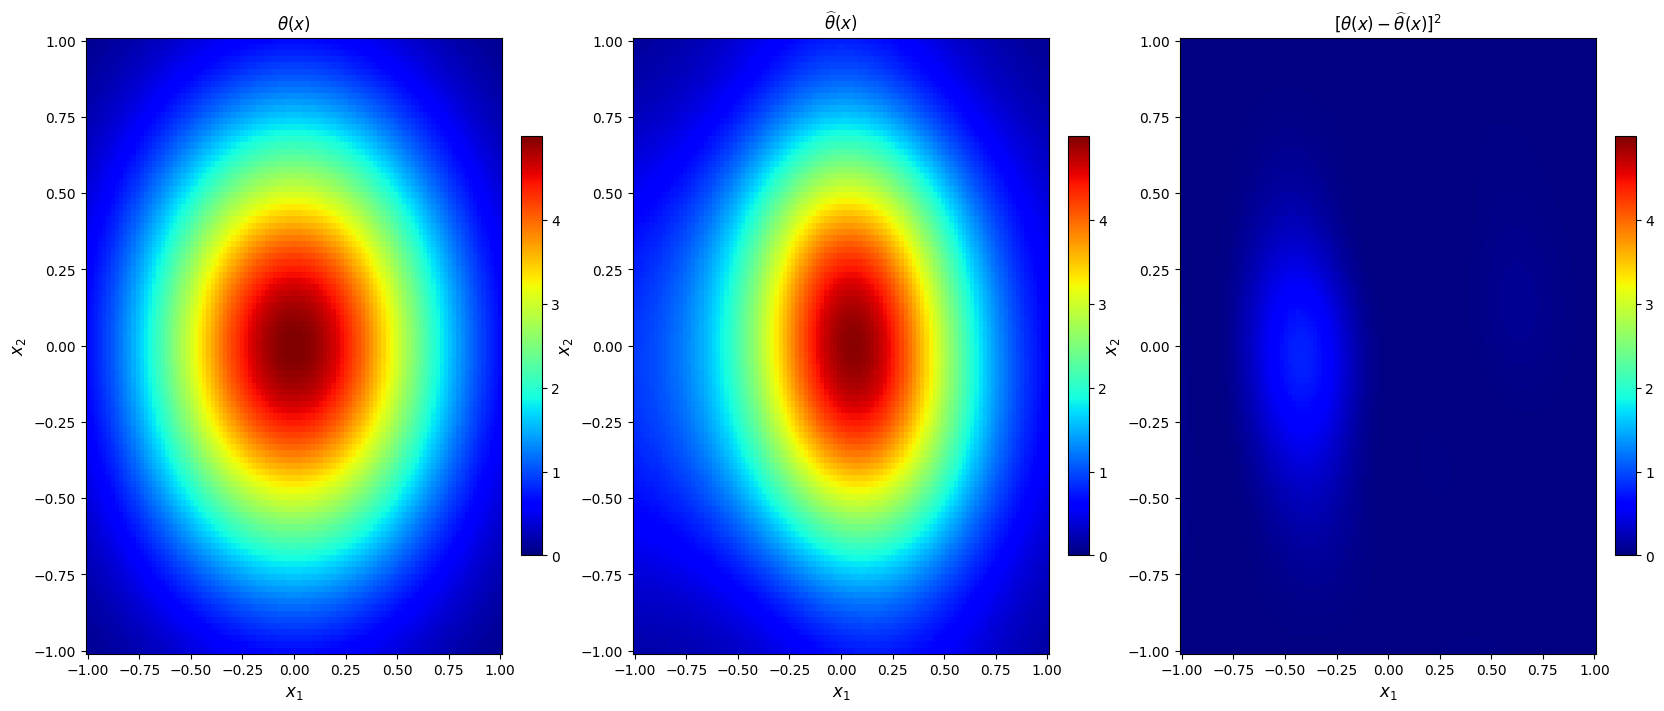

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 8))

xs1, xs2 = np.meshgrid( np.linspace(-1, 1, 100), np.linspace(-1, 1, 100) )
theta_xs1_xs2 = theta_function2(xs1, xs2)
vmin = 0.0
vmax = np.max(theta_xs1_xs2)

mesh1 = ax[0].pcolormesh(xs1, xs2, theta_xs1_xs2, cmap = "jet", vmin = vmin, vmax = vmax)
ax[0].set_title(r"$\theta(x)$")
ax[0].set_xlabel(r"$x_1$", fontsize = 12)
ax[0].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

xs1_all = xs1.flatten()
xs2_all = xs2.flatten()
theta_pred = np.exp(model.predict( np.concatenate([xs1_all[:,None], xs2_all[:,None]], axis = 1), verbose = 0 ))
# theta_pred = model_fixed.predict( np.concatenate([xs1_all[:,None], xs2_all[:,None]], axis = 1), verbose = 0 )
theta_pred = theta_pred.reshape(xs1.shape)

mesh2 = ax[1].pcolormesh(xs1, xs2, theta_pred, cmap = "jet", vmin = vmin, vmax = vmax)
ax[1].set_title(r"$\widehat{\theta}(x)$")
ax[1].set_xlabel(r"$x_1$", fontsize = 12)
ax[1].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)

mesh3 = ax[2].pcolormesh(xs1, xs2, (theta_pred - theta_xs1_xs2)**2, cmap = "jet", vmin = vmin, vmax = vmax)
ax[2].set_title(r"[$\theta(x) - \widehat{\theta}(x)]^2$")
ax[2].set_xlabel(r"$x_1$", fontsize = 12)
ax[2].set_ylabel(r"$x_2$", fontsize = 12)
fig.colorbar(mesh3, ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.show()